In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-16 18:14:47.185856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 18:14:47.672973: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
WIDTH = 512
HEIGHT = 512

# CTA Without Mask

In [ ]:
class ImageSegmentationDatasetCTA(Dataset):

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):

        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        self.images = []

        # Iterate through folders in the root directory
        for folder_name in sorted(os.listdir(os.path.join(self.root_dir))):
            folder_path = os.path.join(self.root_dir, folder_name)
            if os.path.isdir(folder_path):
                # Read images from the "images" subfolder
                image_dir = os.path.join(folder_path, "Images")
                image_file_names = sorted(os.listdir(image_dir))
                self.images.extend([os.path.join(folder_name, "Images", img_name) for img_name in image_file_names])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images[idx])
        image = cv2.imread(image_path)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)  # Rotate image by 90 degrees clockwise

        if self.transforms is not None:
            augmented = self.transforms(image=image)
            # randomly crop + pad image to desired size
            encoded_inputs = self.feature_extractor(augmented['image'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, return_tensors="pt")

        for k, v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()  # remove batch dimension

        return encoded_inputs

In [ ]:
root_dir = "/home/hn/Downloads/Nancy_Downloads/New_CTA_Downloaded_dataset/5G/D_Folders"
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

full_datasetCTA = ImageSegmentationDatasetCTA(root_dir, feature_extractor)

/home/hn/.local/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
len(full_datasetCTA)

2840

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


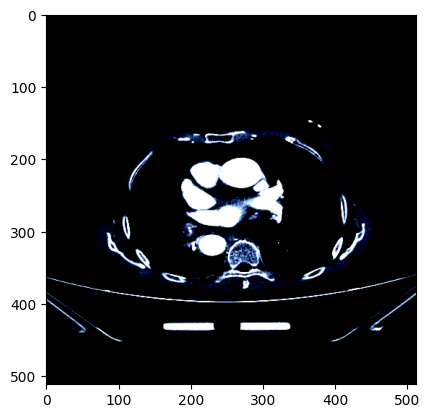

In [ ]:
encoded_inputs = full_dataset[80]
image = encoded_inputs["pixel_values"].numpy()
plt.imshow(image.transpose(1, 2, 0) )

In [ ]:
test_dataloader = DataLoader(full_dataset, batch_size=1)

In [ ]:
# classes = pd.read_csv('class_dict_seg.csv')['name']
id2label = {0: 'background', 1: 'aortic', 2: 'arc', 3: 'asc', 4: 'dec', 5: 'body'}
label2id = {0: 'background', 1: 'aortic', 2: 'arc', 3: 'asc', 4: 'dec', 5: 'body'}

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load the saved model state_dict
checkpoint = torch.load('/home/hn/Downloads/Nancy_Downloads/New_CTA_Downloaded_dataset/Segmentation_Models/SegFormer_EP20.pth')
model.load_state_dict(checkpoint)

optimizer = AdamW(model.parameters(), lr=0.00006)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model Loaded Successfully!")

/home/hn/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Loaded Successfully!


In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 84597958


In [ ]:
model.eval()
pred = []
input_images = []
predicted_masks = []

with torch.no_grad():
    for idx, batch in enumerate(test_dataloader):
        pixel_values = batch["pixel_values"].to(device)

        outputs = model(pixel_values=pixel_values)
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=(pixel_values.shape[-2], pixel_values.shape[-1]), mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        pred_mask = torch.argmax(outputs.logits, dim=1).detach().cpu().numpy()[0]

        input_images.append(pixel_values[0].permute(1, 2, 0).cpu().numpy())
        predicted_masks.append(pred_mask)

print("Testing completed.")

Testing completed.


In [ ]:
def visualize_mask(image, pred_mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='gray')  # Assuming pred_mask is the predicted segmentation mask
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


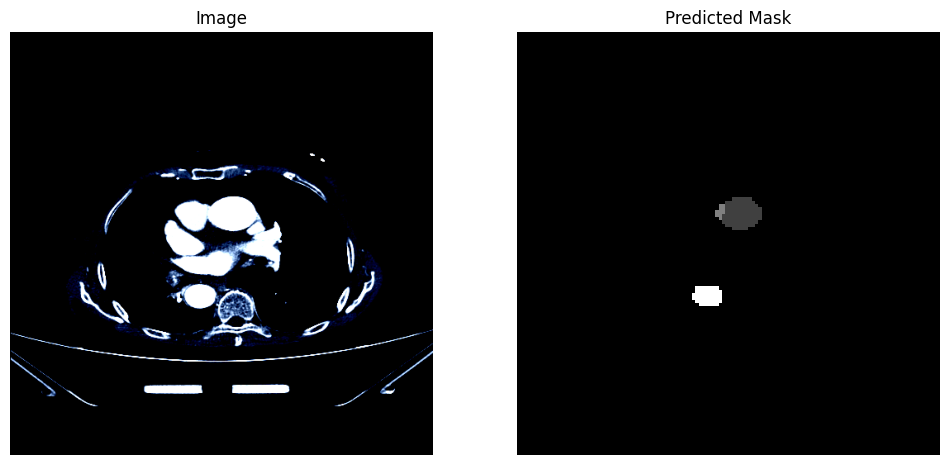

In [ ]:
visualize_mask(input_images[80], predicted_masks[80])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


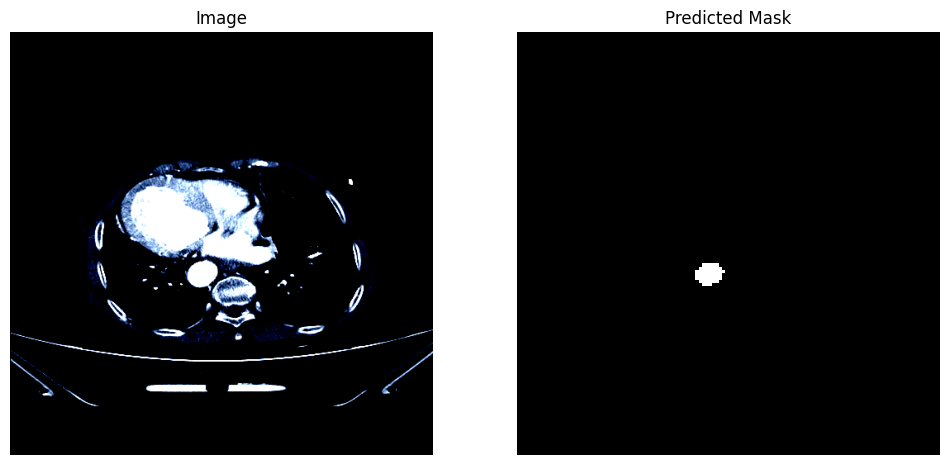

In [ ]:
visualize_mask(input_images[60], predicted_masks[60])